# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

В 3 разных датасетах находятся данные геологоразведки в трех регионах и содержат следующие сведения: 
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

В ходе работы над проектом нам предстоит:
- изучение данных, подготовка их к моделированию;
- обучение моделей для каждого региона (А, В и С);
- составление функция расчета прибыли в регионе, расчет прибыли и рисков за каждом регионе.

**Цель проекта:** Построить модель, которая определит регион, где добыча принесёт наибольшую прибыль.

## Загрузка и подготовка данных

Первоначально загрузим необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression

from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

Выберем уникальный код для `random_state`, который назовем `random_magic`.

In [2]:
random_magic = 3301

Далее произведем загрузку данных датасетов, регионы назовем как регион А, регион В и регион С.

In [3]:
try:
    df_region_A = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
except:
    df_region_A = pd.read_csv('D:/learn_data/geo_data_0.csv')

In [4]:
try:
    df_region_B = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
except:
    df_region_B = pd.read_csv('D:/learn_data/geo_data_1.csv')

In [5]:
try:
    df_region_C = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
except:
    df_region_C = pd.read_csv('D:/learn_data/geo_data_2.csv')

Создадим функцию для просмотра базовой информации датасетов и через нее взглянем на основные сведения из каждого региона. 

In [6]:
def print_base_info(df_region):
    display(df_region.head(5))
    print('\n')
    print(df_region.info())

In [7]:
print_base_info(df_region_A)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [8]:
print_base_info(df_region_B)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [9]:
print_base_info(df_region_C)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Как мы видим, во всех датасетах имеется по 100000 объектов, пропусков не имеется, строковый столбец `'id'` нам в дальнейшем не понадобится, столбцы `'f0`, `'f1'`, `'f2'` содержат признаки, на которых мы будем обучать модели, столбец `'product'` содержит целевой признак.

Предлагаем подробнее изучить данные по регионам с целью оценки распределения и корреляции признаков.

**Оценка распределения значений признаков**

Создадим функции, которые будут выводить отображение информации `discribe` о признаках каждой колонки в текстовом и графическом формате (гистограмма и "ящик с усами").

In [10]:
def describe_column_numeric(column, df):
    print('Признак', column, ':')

    print(df[column].describe())
    
    fig = px.histogram(
        df, 
        x = column, 
        marginal = 'box', 
        opacity = 0.7,
        title = f'Распределение значений признака {column}'
    )

    fig.update_layout(xaxis_title=f'Значения признака {column}', yaxis_title='Частота встречаемости')
    fig.show();

Рассмотрим данные в регионе А.

Как мы видим, распределение признака `f0` в регионе А не являеся нормальным, в то же время оно относительно симметрично с разбросом приблизительно от *-1.4* до *2.36* со средним *0.5*. 

Как мы видим, распределение признака `f1` в регионе А не являеся нормальным, в то же время оно относительно симметрично с разбросом приблизительно от *-0.84* до *1.34* со средним *0.25*. 

Как мы видим, распределение признака `f2` в регионе А являеся нормальным, с разбросом приблизительно от *-12* до *16* со средним *2.5*. 

Регион В

Как мы видим, распределение признака `f0` в регионе В не являеся нормальным, в то же время оно относительно симметрично с разбросом приблизительно от *-31* до *29* со средним *1.14*. 

Как мы видим, распределение признака `f1` в регионе В являеся нормальным с разбросом приблизительно от *-26* до *18.7* со средним *-4.8*. 

Как мы видим, распределение признака `f2` в регионе В не являеся нормальным, блее того, оно распределено приблизительно от *0* до *5* со средним *2.5*, при этом все числа очень близки к целочисленным. Давайте взглянем на значения признака `f2` в первых 10 строках датасета региона В. 

In [17]:
df_region_B['f2'].head(10)

0   -0.005876
1    0.999183
2    5.001160
3    4.999415
4    5.004363
5    3.003647
6    4.002382
7    2.004588
8    4.998647
9    4.997844
Name: f2, dtype: float64

Таким образом, значения признака `f2`является практически приближены к категориальным (отличия от целочсленных значений в тысячных долях чисел). Причину этого мы не знаем, поскольку нам неизвестно даже, измерения какого параметра заложено в этом признаке. Возможно эти данные созданы искусственно, но примем как данность верность значений параметра в целях осуществелния работы по проекту. Также будем считать, что не имелось и утечки целевого признака. 

Регион С

Как мы видим, распределение признака `f0` в регионе С являеся нормальным с разбросом приблизительно от *-8.76* до *7.24* со средним *0*. 

Как мы видим, распределение признака `f1` в регионе С являеся нормальным с разбросом приблизительно от *-7.08* до *7.84* со средним *0*. 

Как мы видим, распределение признака `f2` в регионе С являеся нормальным с разбросом приблизительно от *-11.97* до *16.74* со средним *2.5*. 

**Проверка корреляции признаков**

**Регион А**

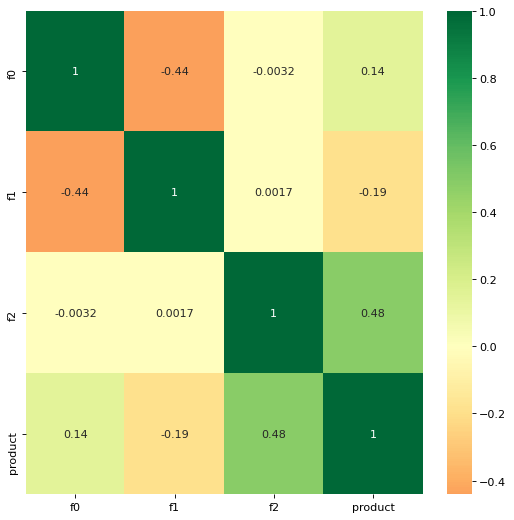

In [21]:
plt.figure(figsize=(8,8), dpi= 80)
sns.heatmap(df_region_A.corr(), cmap='RdYlGn', center=0, annot=True);

В регионе А имеется средняя положительная корреляция между целевым признаком и признаком `f2`, также имеется средяя отрцательная корреляция между признаками `f0` и `f1`.

**Регион В**

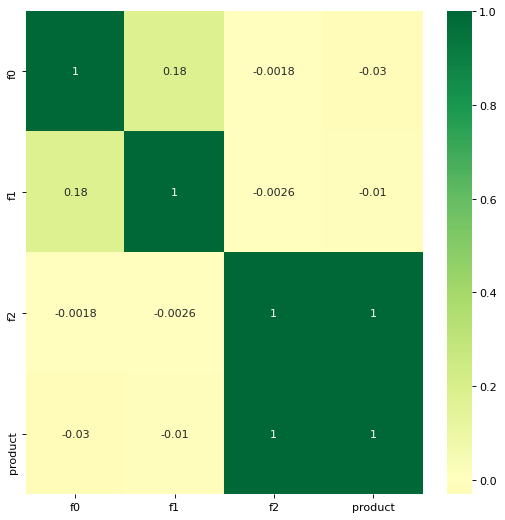

In [22]:
plt.figure(figsize=(8,8), dpi= 80)
sns.heatmap(df_region_B.corr(), cmap='RdYlGn', center=0, annot=True);

В регионе В имеется практически полная положительная корреляция между целевым признаком и признаком `f2`, также имеется небольшая положительная корреляция между признаками `f0` и `f1`.

**Регион С**

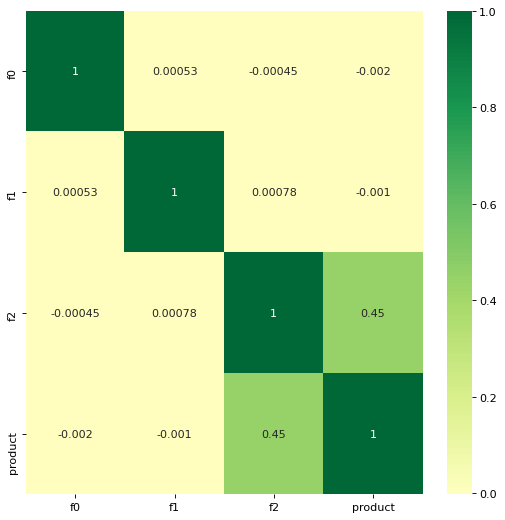

In [23]:
plt.figure(figsize=(8,8), dpi= 80)
sns.heatmap(df_region_C.corr(), cmap='RdYlGn', center=0, annot=True);

В регионе С имеется средняя положительная корреляция между целевым признаком и признаком `f2`, между остальными признаками корреляции не наблюдается.

В ходе изучения данныз установлено, что признаки, указанные в столбце `'id'`, являются просто идентификационным обозначением и не несут какой-либо значимой информации, поэтому просто удалим данный стобец.

In [24]:
df_region_A.drop('id', axis=1, inplace=True)
df_region_B.drop('id', axis=1, inplace=True)
df_region_C.drop('id', axis=1, inplace=True)

**Выводы:** Изучив датасеты 3 регионов, мы видим, что они сдержат сведения о 100000 объектов в каждом регионе, нулевых данных не имеется, однако характер данных, заложенных в столбцах `f0`, `f1` и `f2`, нам не известен. В то же время, из изучения данных понятно, что они разичны от региона к региону, поскольку имеют разные разбросы значений и распределение. Причины этого тоже неизвестны (вероятно, там содержаться различные в зависимости от региона типы данных) В связи с этим, впоследствии нам надо будет обучать различные модели для каждого региона. 

## Обучение и проверка модели

Сделаем разбивка данных по каждому региону на обучающую и тестовую выборки (в формате 3 к 1).

In [25]:
features_train_a, features_test_a, target_train_a, target_test_a = train_test_split(
    df_region_A.drop(['product'], axis=1), df_region_A['product'], test_size=0.25, random_state=random_magic)

features_train_b, features_test_b, target_train_b, target_test_b = train_test_split(
    df_region_B.drop(['product'], axis=1), df_region_B['product'], test_size=0.25, random_state=random_magic)

features_train_c, features_test_c, target_train_c, target_test_c = train_test_split(
    df_region_C.drop(['product'], axis=1), df_region_C['product'], test_size=0.25, random_state=random_magic)

Создадим функцию для определения метрик.

In [26]:
def print_metrics(y_test,y_pred):
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('Средний предсказанный запас сырья:', y_pred.mean(), 'тыс. баррелей')
    pass

Далее обучим модели для каждого региона. Поскольку согласно условиям проекта необходимо использовать только модели линейной регрессии, предлагаю использовать модель `LassoCV`, которая является линейной моделью Лассо с итеративной подгонкой по пути регуляризации, где лучшая модель выбираеся перекрестной проверкой. Результаты предсказаний сохраним в отдельные переменные.

**Регион А**

In [27]:
lasso_cv_a = LassoCV(cv=10, random_state=random_magic, selection='random').fit(features_train_a, target_train_a)
print('RMSE', lasso_cv_a.mse_path_.mean() ** 0.5)

RMSE 38.63742225290229


In [28]:
predict_a = lasso_cv_a.predict(features_test_a)
print_metrics(target_test_a, predict_a)

RMSE: 37.71306995929867
Средний предсказанный запас сырья: 92.45762025639999 тыс. баррелей


**Регион В**

In [29]:
lasso_cv_b = LassoCV(cv=10, random_state=random_magic, selection='random').fit(features_train_b, target_train_b)
print('RMSE', lasso_cv_b.mse_path_.mean() ** 0.5)

RMSE 12.782439202869877


In [30]:
predict_b = lasso_cv_b.predict(features_test_b)
print_metrics(target_test_b, predict_b)

RMSE: 0.8932880334500253
Средний предсказанный запас сырья: 68.8059318456611 тыс. баррелей


**Регион С**

In [31]:
lasso_cv_c = LassoCV(cv=10, random_state=random_magic, selection='random').fit(features_train_c, target_train_c)
print('RMSE', lasso_cv_c.mse_path_.mean() ** 0.5)

RMSE 40.41622081118369


In [32]:
predict_c = lasso_cv_c.predict(features_test_c)
print_metrics(target_test_c, predict_c)

RMSE: 40.12052375440618
Средний предсказанный запас сырья: 95.25759604121873 тыс. баррелей


**Выводы:**
Как мы видим, в регионах А и С в целом схожая ситуация, средний предсказанный запас сырья примерно от `92 тыс. до 95 тыс. баррелей`. Однако велико значение корня из среднекваратичной ошибки (RMSE) от `37` до `40`. В то же время в регионе В хотя и при меньшем количестве предсказанного количества сырья на скважину (`~68 тыс. баррелей`), показатель RMSE существенно ниже и составляет всего `0,89`. Предсказанные моделями данные для каждого региона сохранены в переменных `predict_a`, `predict_b` и `predict_c` и будут использованы нами далее.

## Подготовка к расчёту прибыли

Зададим переменные, которые нам даны по условям проекта.

In [33]:
budget = 10000000000
chosen_points = 500
best_points = 200
price_for_barrel = 450

Посмотрим, какие необходимые должны быть результаты для осуществления безубыточной добычи.

In [34]:
average_profit_per_point = budget / best_points
print('Средняя необходимая прибыль на скважину:', average_profit_per_point, 'руб.')

average_barrels_per_point = average_profit_per_point  / price_for_barrel / 1000
print('Средний необходимый объем нефти на скважину:',average_barrels_per_point, 'тыс. баррелей')

average_barrels = budget / price_for_barrel / 1000
print('Средний неободимый объем нефти на регион:',average_barrels, 'тыс. баррелей')

Средняя необходимая прибыль на скважину: 50000000.0 руб.
Средний необходимый объем нефти на скважину: 111.11111111111111 тыс. баррелей
Средний неободимый объем нефти на регион: 22222.222222222223 тыс. баррелей


А теперь взгянем на действительные запасы нефти в среднем на скважину в каждом регионе.

In [35]:
print('Средний запас фактичекой нефти на скважину в регионе A:', df_region_A['product'].mean(), 'тыс. баррелей')
print('Средний запас фактичекой нефти на скважину в регионе B:', df_region_B['product'].mean(), 'тыс. баррелей')
print('Средний запас фактичекой нефти на скважину в регионе C:', df_region_C['product'].mean(), 'тыс. баррелей')

Средний запас фактичекой нефти на скважину в регионе A: 92.50000000000001 тыс. баррелей
Средний запас фактичекой нефти на скважину в регионе B: 68.82500000000002 тыс. баррелей
Средний запас фактичекой нефти на скважину в регионе C: 95.00000000000004 тыс. баррелей


**Выводы:**
Как мы видим, запасы нефти в среднем на скважину в каждом регионе ниже, чем небходимо для безубыточной добычи нефти. Таким образом и возникает необходимость разрабаывать только лучшие скважины, где объем нефти будет выше 111.11 тыс. баррелей.

## Расчёт прибыли и рисков 

In [36]:
def revenue(target, predict):
    predict_sorted = predict.sort_values(ascending=False)
    selected = target.loc[predict_sorted.index.to_list()][:best_points]
    return (selected.sum() * price_for_barrel * 1000) - budget

In [37]:
def bootstrap(target_test, predict, region):
    state = np.random.RandomState(random_magic)
    values = []
    target = target_test.reset_index(drop=True)
    predictions = pd.Series(predict)
    count = 0 
    for i in range(1000):
 
        target_subsample = target.sample(500, replace=True, random_state=state)
        predictions_subsample = predictions.loc[target_subsample.index.to_list()]
        value = revenue(target_subsample, predictions_subsample)
        values.append(value)
        
        if value < 0: 
            count += 1 
        
    risk = count / 1000
 
    values = pd.Series(values)
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975) 
    
    print('Средняя прибыль по региону', region, 'составляет:', round(values.mean(), 2), 'руб. с риском в', 
          round(risk * 100, 2), '%')
    print('Доверительный интервал в регионе составляет от', round(lower, 2),'до', round(upper, 2))

In [38]:
bootstrap(target_test_a, predict_a, 'A')

Средняя прибыль по региону A составляет: 471176510.37 руб. с риском в 3.6 %
Доверительный интервал в регионе составляет от -45319034.46 до 990832013.95


In [39]:
bootstrap(target_test_b, predict_b, 'B')

Средняя прибыль по региону B составляет: 505409319.17 руб. с риском в 1.0 %
Доверительный интервал в регионе составляет от 80257349.83 до 947108434.52


In [40]:
bootstrap(target_test_c, predict_c, 'C')

Средняя прибыль по региону C составляет: 359758112.3 руб. с риском в 10.8 %
Доверительный интервал в регионе составляет от -194198526.0 до 910898968.84


**Выводы:**
Данные были обработаны и рассчитаны прибыль, доверительные интервалы и риски в каждом регионе.
По условиям проекта (вероятность убитков меее 2,5%) проходится отсеять регион А и регион С, поскольку в них риски достаточно велики. Остается один единственный вариант разработки - регион В, чей риск существенно ниже требуемого. Кроме того доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин должна окупиться.

**Общие выводы:**

При выполнении данного проекта было выполнено:
- Изучены данные. Проведена подготовка данных к моделированию.
- Обучена модель для каждого региона (А, В и С).
- Составлена функция расчета прибыли в регионе.
- Посчитана прибыль и риски за каждый регион и обоснован выбор региона.

В результате проекта `регион В` получился одним из лучших по показателям предсказывания, хотя данные не выглядят нормально распределенными (согласно условиям проекта все данные синтетические). Таким образом, нами предлагается `регион В` для разработки скважин по причине минмального риска (около 1%), нахождения всего доверительного интервала в зоне прибыли и самом высоком показателе предсказанного среднего дохода (505409319.17 руб.).  